In [ ]:
# 범주형 데이터를 인코딩하여 학습 + randomized_search(cb 자체)

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc
from scipy.stats import randint

In [ ]:
df = pd.read_csv('../data/okcupid_preprocessed.csv')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  59934 non-null  int64  
 1   sex                         59934 non-null  int64  
 2   orientation                 59934 non-null  int64  
 3   drugs                       59934 non-null  int64  
 4   education                   53310 non-null  float64
 5   height                      59934 non-null  float64
 6   job                         51739 non-null  object 
 7   last_online                 59934 non-null  object 
 8   sign                        59934 non-null  int64  
 9   age                         59934 non-null  int64  
 10  status                      59934 non-null  object 
 11  diet                        35547 non-null  object 
 12  location                    59934 non-null  object 
 13  pets                        400

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40276 entries, 0 to 59933
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  40276 non-null  int64  
 1   sex                         40276 non-null  int64  
 2   orientation                 40276 non-null  int64  
 3   drugs                       40276 non-null  int64  
 4   education                   38925 non-null  float64
 5   height                      40276 non-null  float64
 6   job                         38905 non-null  object 
 7   last_online                 40276 non-null  object 
 8   sign                        40276 non-null  int64  
 9   age                         40276 non-null  int64  
 10  status                      40276 non-null  object 
 11  diet                        29227 non-null  object 
 12  location                    40276 non-null  object 
 13  pets                        32846 no

In [68]:
df["last_online_dt"] = pd.to_datetime(df["last_online"])
ref_date = df["last_online_dt"].max() # 마지막 관측 시간

# churn 정의
THRESHOLD_DAYS = 30
df["inactive_days"] = (ref_date - df["last_online_dt"]).dt.days
df["churn"] = (df["inactive_days"] >= THRESHOLD_DAYS).astype(int)

print("ref_date:", ref_date)
print("churn rate:", df["churn"].mean())

ref_date: 2012-07-01 00:00:00
churn rate: 0.24101201708213327


In [69]:
# X 데이터 정리
drop_cols = [
    "Unnamed: 0", "job", "last_online", "last_online_dt", "inactive_days", "churn",
     "status", "diet", "location", "pets", "city", "age"
]

drop_list = []

for col in drop_cols:
    if col in df.columns:
        drop_list.append(col)

X = df.drop(columns=drop_list)

# 라벨 데이터
y = df["churn"]

print("X shape:", X.shape)

X shape: (40276, 36)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
train_pool = Pool(X_train, y_train)

cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=0,
    verbose=0,
    iterations=2000,
    od_type="Iter",
    od_wait=60,
    auto_class_weights="Balanced"
)



params = {
    "depth": randint(4, 9),
    "learning_rate": np.linspace(0.03, 0.15, 25),
    "l2_leaf_reg": np.logspace(0, np.log10(50), 20),
    "rsm": np.linspace(0.6, 1.0, 9),
    "random_strength": np.linspace(0, 2, 9),
    "bagging_temperature": np.linspace(0, 1, 6),
}

cb.randomized_search(params, X=train_pool, cv=3, n_iter=5, search_by_train_test_split=False, shuffle=True, stratified=True, verbose=True, plot=False)
cb.get_params()
cb.fit(X_train, y_train)

Training on fold [0/3]

bestTest = 0.6275071033
bestIteration = 85

Training on fold [1/3]

bestTest = 0.6162894286
bestIteration = 64

Training on fold [2/3]

bestTest = 0.6247712328
bestIteration = 279

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6221438	best: 0.6221438 (0)	total: 14.9s	remaining: 59.5s
Training on fold [0/3]

bestTest = 0.6273897183
bestIteration = 42

Training on fold [1/3]

bestTest = 0.6169517731
bestIteration = 42

Training on fold [2/3]

bestTest = 0.6228851651
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6194405	best: 0.6221438 (0)	total: 25.1s	remaining: 37.7s
Training on fold [0/3]

bestTest = 0.628669564
bestIteration = 53

Training on fold [1/3]

bestTest = 0.6193302033
bestIteration = 54

Training on fold [2/3]

bestTest = 0.6247120833
be

In [72]:
cb.get_params()
print(f"best_params: {cb.get_params()}") 

best_params: {'iterations': 2000, 'loss_function': 'Logloss', 'od_wait': 60, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 0, 'eval_metric': 'AUC', 'bagging_temperature': 0.8, 'rsm': 0.7, 'random_strength': 0, 'depth': 4, 'learning_rate': 0.125, 'l2_leaf_reg': 1.5095202653900996}


In [73]:
cb.fit(X_train, y_train)

In [75]:
proba = cb.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.05, 0.95, 91)
best_thres = None
best_f1 = -1

for t in thresholds:
    pred_t = (proba >= t).astype(int)
    f1 = f1_score(y_test, pred_t, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thres = t
        
print("best threshold:", best_thres, "best F1:", best_f1)
pred_best = (proba >= best_thres).astype(int)
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred_best, zero_division=0))

best threshold: 0.16999999999999998 best F1: 0.39546073536087156
ROC-AUC: 0.597466587223702
              precision    recall  f1-score   support

           0       0.82      0.35      0.49      9171
           1       0.27      0.75      0.40      2912

    accuracy                           0.45     12083
   macro avg       0.54      0.55      0.44     12083
weighted avg       0.68      0.45      0.47     12083



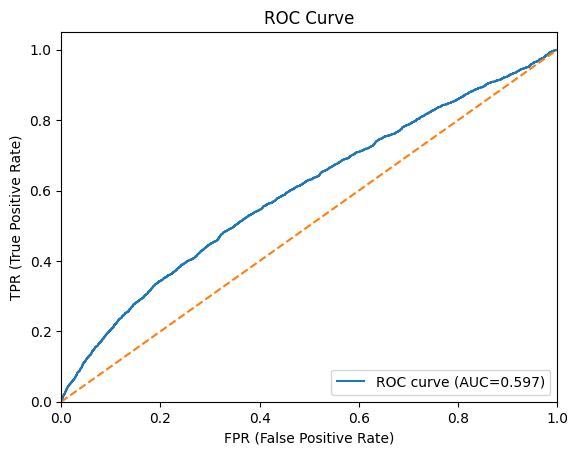

In [76]:
fpr, tpr, th = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

100%|===================| 12081/12083 [14:42<00:00]        

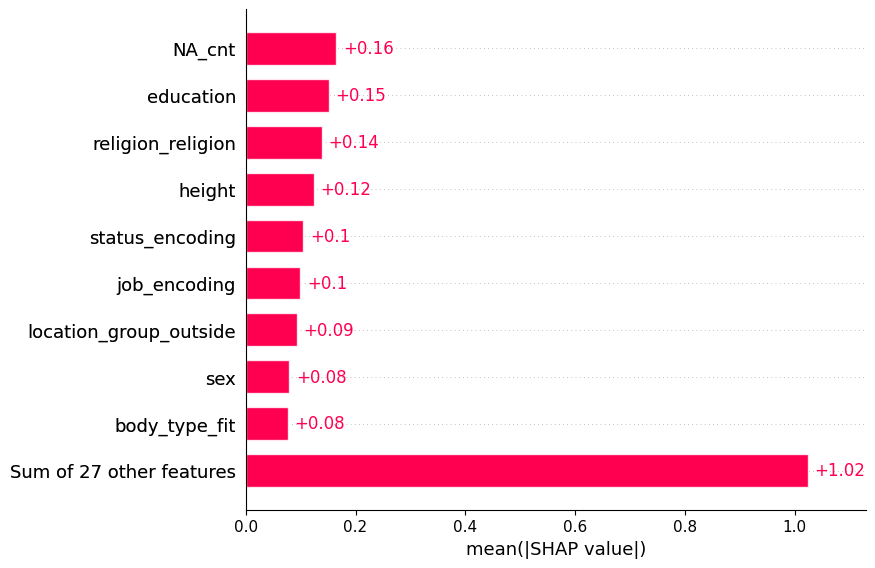

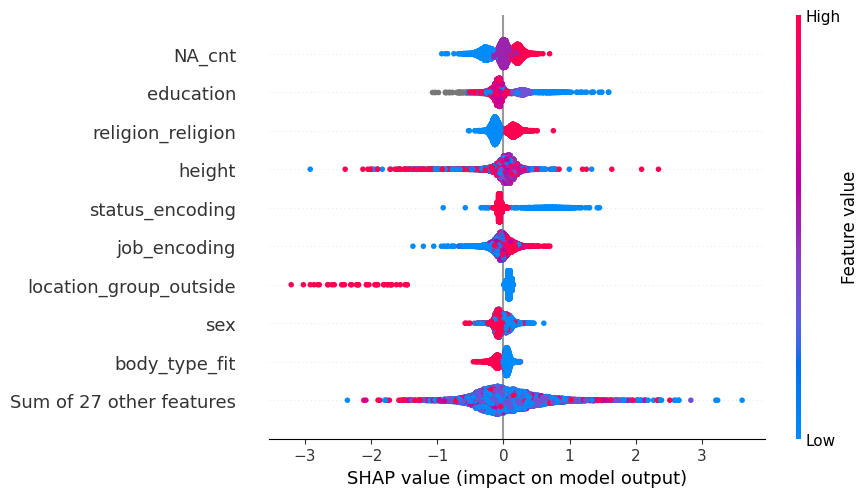

In [ ]:
# import shap

# X_train = X_train.astype('float')
# X_test = X_test.astype('float')

# explainer = shap.Explainer(cb, X_train)

# shap_values = explainer(X_test)

# shap.plots.bar(shap_values)

# shap.plots.beeswarm(shap_values)